In [15]:
import numpy as np
import dm4bem
import pandas as pd
import matplotlib as plt
from modélisationV6 import*

In [16]:
# # State-space
# temperature nodes
# flow-rate branches

#print(help(dm4bem.tc2ss))
Adf = pd.DataFrame(A, index=q, columns=θ)
Cdf= pd.Series(C, index=θ)
Gdf = pd.Series(G, index=q)
bdf = pd.Series(b, index=q)
fdf = pd.Series(f, index=θ)
ydf= pd.Series(y, index=θ)

TC = {'A':Adf, 'C':Cdf, 'G':Gdf, 'b':bdf, 'f':fdf, 'y':ydf}
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

In [17]:



         # vector of nonzero elements of vector f : [f0, f3, f7, f8, f10, f14, f16, f17, f19, f20, f22, f23, f25, f26, f30, f32]
#%%
lamda = np.linalg.eig(As)[0] # eigenvalues
dtmax = 2*min(-1/lamda)
dt = dm4bem.round_time(dtmax)

t_settle=4*max(-1/lamda)
duration=np.ceil(t_settle/3600)*3600
n = int(np.floor(duration / dt))    # number of time steps
V_To = T0 * np.ones(n)        # outdoor temperature
V_Ti_sp = Ti_sp * np.ones(n)
bT = np.array([T0, T0, T0, T0, T0, T0, Ti_sp]) # vector of the nonzero elements of vector b : temperatures for the conductances 0, 1, 7, 35, 37, 39 and 40.

fQ = np.array([Qa, Φo, Qin, Φo, Φo, Φi, Φo, Φi, Φi, Φi, Φi, Φi, Φi, Φi, Φo, Φo])


In [18]:
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'us = {us}')


us = q0        T0
q1        T0
q7        T0
q35       T0
q37       T0
q39    Ti_sp
q40       T0
θ3        Φo
θ7        Φi
θ8        Φo
θ10       Φo
θ14       Φi
θ16       Φo
θ17       Φi
θ19       Φi
θ20       Φi
θ22       Φi
θ23       Φi
θ25       Φi
θ26       Φi
θ30       Φo
θ32       Φo
dtype: object


In [21]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps
# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")



f0 = Qa * np.ones(n)       # auxiliary heat gains
f3 = Qout * np.ones(n)      # solar radiation absorbed by the outdoor part of the glasses and the walls
f7 = Qin * np.ones(n)       # solar radiation absorbed by the outdoor part of the glasses and the walls
Φa=Qa=Φi=Φo=0*np.ones(n)
data = {'T0': T0, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)



C:\Users\Aymeric\AppData\Local\Temp\ipykernel_10144\3934613363.py:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time = pd.date_range(start="2000-01-01 00:00:00",


In [22]:
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0.0                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

In [24]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

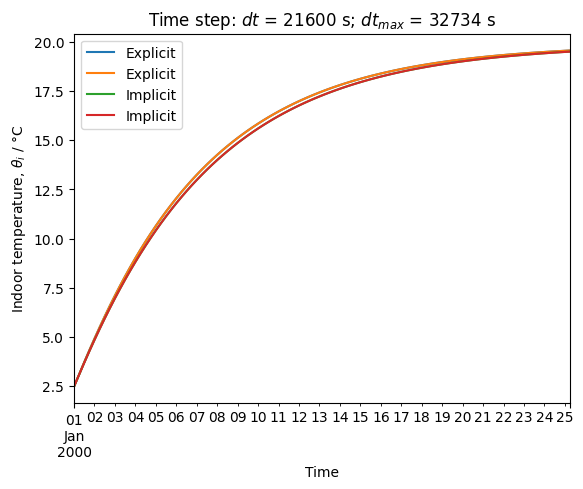

In [25]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {dtmax:.0f} s')
plt.show()